# Imports and setup

In [1]:
import os, glob
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from monai.losses import DiceLoss, DiceCELoss, GeneralizedDiceLoss, GeneralizedDiceFocalLoss
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    Resized,
    RandRotate90d,
    RandCropByPosNegLabeld,
    NormalizeIntensityd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, UNet, AttentionUnet, SwinUNETR, VNet
from monai.networks.layers import Norm

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

#from monai.data.utils import pad_list_data_collate

import torch

%matplotlib inline

print_config()

MONAI version: 0.9.dev2223
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0428f5a29f1fdc577f2c558490266d9db00583e3
MONAI __file__: /home/trojan/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
root_dir = os.path.join(os.getcwd(), "monai_data_directory")
INPUT_SIZE = (256,256,16)  # will resize later
print(root_dir)

/home/trojan/skia_projects/3D-CT-Artery-Segmentation/monai/monai_data_directory


# Setup transforms for training and validation

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.4, 0.4, 0.5),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        NormalizeIntensityd(keys=["image"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=INPUT_SIZE, mode='nearest-exact'),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.4, 0.4, 0.5),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        NormalizeIntensityd(keys=["image"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=INPUT_SIZE, mode='nearest-exact'),
        ToTensord(keys=["image", "label"]),
    ]
)

# Dataset and data loaders

In [4]:
data_dir = '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_16_groups'

train_images_path = os.path.join(data_dir, 'train/images')
train_labels_path = os.path.join(data_dir, 'train/labels')
val_images_path = os.path.join(data_dir, 'val/images')
val_labels_path = os.path.join(data_dir, 'val/labels')

train_images_list = sorted(glob.glob(train_images_path + '/*.nii.gz'))
train_labels_list = sorted(glob.glob(train_labels_path + '/*.nii.gz'))
val_images_list = sorted(glob.glob(val_images_path + '/*.nii.gz'))
val_labels_list = sorted(glob.glob(val_labels_path + '/*.nii.gz'))

train_files = [{'image': image_name, 'label': label_name} for image_name,label_name in zip(train_images_list, train_labels_list)]
val_files = [{'image': image_name, 'label': label_name} for image_name,label_name in zip(val_images_list, val_labels_list)]

In [5]:
print(len(train_files))
print(len(val_files))

548
101


In [6]:
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_num=len(train_files),
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, pin_memory=True,
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=len(val_files)
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, pin_memory=True,
)

Loading dataset: 100%|████████████████████████| 101/101 [10:18<00:00,  6.13s/it]


In [7]:
# train_ds = Dataset(
#     data=train_files,
#     transform=train_transforms,
# )
# train_loader = DataLoader(
#     train_ds, batch_size=1, shuffle=True, pin_memory=True
# )
# val_ds = Dataset(
#     data=val_files, 
#     transform=val_transforms
# )
# val_loader = DataLoader(
#     val_ds, batch_size=1, shuffle=False, pin_memory=True
# )

image shape: torch.Size([1, 256, 256, 16]), label shape: torch.Size([1, 256, 256, 16])


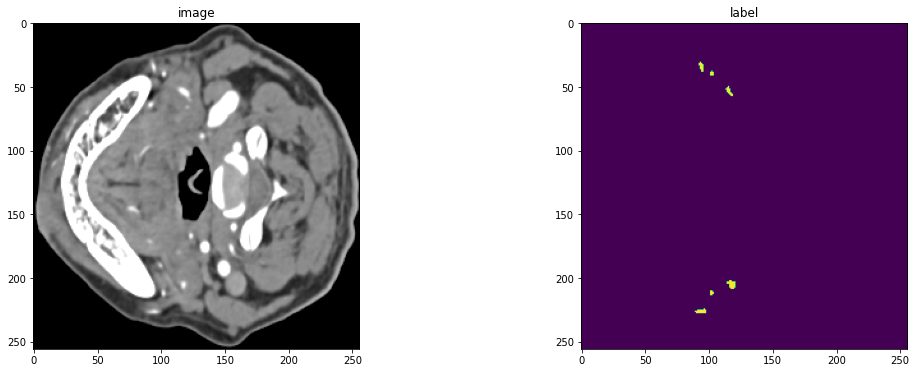

In [8]:
case_num = 1
slice_number = 10

data = val_ds[case_num]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_number].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_number].detach().cpu())
plt.show()

In [9]:
# Check label values
print(np.unique(val_ds[case_num]["label"], return_counts=True))

(array([0., 2.], dtype=float32), array([1047116,    1460]))


# Create model, loss and optimizer

In [18]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VNet(
#     in_channels=1,
#     out_channels=3,
# ).to(device)

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=INPUT_SIZE,
    feature_size=32,  # 16
    hidden_size=768,
    mlp_dim=1024,  # 3072
    num_heads=12,
    pos_embed="perceptron",  # "conv", "perceptron"
    norm_name="instance",  # "batch", "instance"
    res_block=True,
    dropout_rate=0.0,
).to(device)

# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=3,
#     channels=(16,32,64,128,256),
#     strides=(2,2,2,2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)

# model = AttentionUnet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=3,
#     channels=(16,32,64,128,256),
#     strides=(2,2,2,2),
#     ).to(device)

ce_weight = torch.tensor([1,10000,10000])
ce_weight = ce_weight.type(torch.cuda.FloatTensor)

#loss_function = DiceCELoss(to_onehot_y=True, softmax=True, ce_weight=ce_weight)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True)
# loss_function = GeneralizedDiceFocalLoss(to_onehot_y=True, softmax=True, lambda_focal=0.6, lambda_gdl=0.6, focal_weight=ce_weight)
#loss_function = DiceLoss(to_onehot_y=True, softmax=True)


torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
#inferer = SimpleInferer()

# Training process

In [19]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            #val_outputs = inferer(val_inputs, model)
            val_outputs = sliding_window_inference(val_inputs, INPUT_SIZE, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            mean_dice_val = dice_metric.aggregate().item()
            epoch_iterator_val.set_description(
                "Validation (Dice=%2.5f)" % (mean_dice_val)
            )
        dice_metric.reset()
    return mean_dice_val

In [20]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    
    weights_path = os.path.join(root_dir, "best_metric_model.pth")
    if os.path.exists(weights_path):
        checkpoint = torch.load(weights_path)
        model.load_state_dict(checkpoint)
    else:
        print("No checkpoint found.")
        
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validation (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [21]:
max_iterations = int(len(train_ds) * 1000)
eval_num = int(len(train_ds))
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

No checkpoint found.


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

No checkpoint found.


Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5545665621757507 Current Avg. Dice: 0.5545665621757507


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5545665621757507 Current Avg. Dice: 0.5481670498847961


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5545665621757507 Current Avg. Dice: 0.5543898940086365


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5555075407028198 Current Avg. Dice: 0.5555075407028198


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.555576741695404 Current Avg. Dice: 0.555576741695404


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5587201714515686 Current Avg. Dice: 0.5587201714515686


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5619701147079468 Current Avg. Dice: 0.5619701147079468


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5619701147079468 Current Avg. Dice: 0.557371973991394


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5619701147079468 Current Avg. Dice: 0.5599919557571411


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5619701147079468 Current Avg. Dice: 0.5595378875732422


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5619701147079468 Current Avg. Dice: 0.5614625215530396


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5641411542892456 Current Avg. Dice: 0.5641411542892456


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5653099417686462 Current Avg. Dice: 0.5653099417686462


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5677475333213806 Current Avg. Dice: 0.5677475333213806


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5699282884597778 Current Avg. Dice: 0.5699282884597778


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5704910755157471 Current Avg. Dice: 0.5704910755157471


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5704910755157471 Current Avg. Dice: 0.5700501799583435


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5704910755157471 Current Avg. Dice: 0.5661279559135437


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5731229782104492 Current Avg. Dice: 0.5731229782104492


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5735649466514587 Current Avg. Dice: 0.5735649466514587


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5735649466514587 Current Avg. Dice: 0.5677592158317566


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5753213763237 Current Avg. Dice: 0.5753213763237


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5766908526420593 Current Avg. Dice: 0.5766908526420593


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5819140076637268 Current Avg. Dice: 0.5819140076637268


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5822469592094421 Current Avg. Dice: 0.5822469592094421


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5822469592094421 Current Avg. Dice: 0.5822423100471497


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5822469592094421 Current Avg. Dice: 0.5766705274581909


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5822469592094421 Current Avg. Dice: 0.5768781900405884


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5837152600288391 Current Avg. Dice: 0.5837152600288391


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5837152600288391 Current Avg. Dice: 0.5825867652893066


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.584833562374115 Current Avg. Dice: 0.584833562374115


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.58552485704422 Current Avg. Dice: 0.58552485704422


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5880146622657776 Current Avg. Dice: 0.5880146622657776


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5918850898742676 Current Avg. Dice: 0.5918850898742676


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5919070839881897 Current Avg. Dice: 0.5919070839881897


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5945747494697571 Current Avg. Dice: 0.5945747494697571


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.59510737657547


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.5891657471656799


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.5857657194137573


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.5921958684921265


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.5936650037765503


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.5898373126983643


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.59510737657547 Current Avg. Dice: 0.5922310948371887


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5969750285148621 Current Avg. Dice: 0.5969750285148621


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5990438461303711 Current Avg. Dice: 0.5990438461303711


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5990438461303711 Current Avg. Dice: 0.5926846265792847


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6075688004493713 Current Avg. Dice: 0.6075688004493713


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6075688004493713 Current Avg. Dice: 0.6057787537574768


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6077468991279602 Current Avg. Dice: 0.6077468991279602


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6077468991279602 Current Avg. Dice: 0.6066089868545532


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6095913648605347 Current Avg. Dice: 0.6095913648605347


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6107293367385864 Current Avg. Dice: 0.6107293367385864


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6107293367385864 Current Avg. Dice: 0.6097093224525452


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6107293367385864 Current Avg. Dice: 0.6030341982841492


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6107293367385864 Current Avg. Dice: 0.6106346249580383


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6148175597190857 Current Avg. Dice: 0.6148175597190857


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6148175597190857 Current Avg. Dice: 0.609282910823822


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6148175597190857 Current Avg. Dice: 0.6136021614074707


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6162257194519043 Current Avg. Dice: 0.6162257194519043


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6162257194519043 Current Avg. Dice: 0.6160348653793335


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6162257194519043 Current Avg. Dice: 0.6094522476196289


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6162257194519043 Current Avg. Dice: 0.6137536764144897


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6162257194519043 Current Avg. Dice: 0.6119723320007324


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6162257194519043 Current Avg. Dice: 0.614276647567749


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6186277270317078 Current Avg. Dice: 0.6186277270317078


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6186277270317078 Current Avg. Dice: 0.615965723991394


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6194308400154114 Current Avg. Dice: 0.6194308400154114


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6194308400154114 Current Avg. Dice: 0.6184099316596985


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6208094954490662 Current Avg. Dice: 0.6208094954490662


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6208094954490662 Current Avg. Dice: 0.6193991303443909


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6220670938491821 Current Avg. Dice: 0.6220670938491821


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6220670938491821 Current Avg. Dice: 0.6215267181396484


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6227112412452698 Current Avg. Dice: 0.6227112412452698


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6229991912841797 Current Avg. Dice: 0.6229991912841797


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6229991912841797 Current Avg. Dice: 0.6207523941993713


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6232069134712219 Current Avg. Dice: 0.6232069134712219


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6232069134712219 Current Avg. Dice: 0.6197422742843628


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6232069134712219 Current Avg. Dice: 0.6212663650512695


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6240168213844299 Current Avg. Dice: 0.6240168213844299


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6240168213844299 Current Avg. Dice: 0.6217560768127441


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6242836117744446 Current Avg. Dice: 0.6242836117744446


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6242836117744446 Current Avg. Dice: 0.6206874251365662


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.627449095249176 Current Avg. Dice: 0.627449095249176


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627449095249176 Current Avg. Dice: 0.6270914077758789


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627449095249176 Current Avg. Dice: 0.6261472105979919


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.627816379070282


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.6268379092216492


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.6278055906295776


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.627701997756958


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.6257532238960266


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.6267805695533752


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.627816379070282 Current Avg. Dice: 0.6272245049476624


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6301058530807495 Current Avg. Dice: 0.6301058530807495


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6301058530807495 Current Avg. Dice: 0.6287968158721924


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6304177641868591 Current Avg. Dice: 0.6304177641868591


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6316095590591431 Current Avg. Dice: 0.6316095590591431


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6316095590591431 Current Avg. Dice: 0.6302156448364258


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6316095590591431 Current Avg. Dice: 0.6307701468467712


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6316095590591431 Current Avg. Dice: 0.6282044053077698


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6323333382606506 Current Avg. Dice: 0.6323333382606506


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6333947777748108 Current Avg. Dice: 0.6333947777748108


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6340137124061584 Current Avg. Dice: 0.6340137124061584


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6342306733131409 Current Avg. Dice: 0.6342306733131409


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6342333555221558 Current Avg. Dice: 0.6342333555221558


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6342333555221558 Current Avg. Dice: 0.6327303051948547


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6347126960754395 Current Avg. Dice: 0.6347126960754395


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6347126960754395 Current Avg. Dice: 0.6339402198791504


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6347126960754395 Current Avg. Dice: 0.6343849897384644


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6347126960754395 Current Avg. Dice: 0.6346992254257202


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6353963613510132 Current Avg. Dice: 0.6353963613510132


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.6365944147109985


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.6365180611610413


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.6340125203132629


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.6351507902145386


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.6353257894515991


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.6354761123657227


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6365944147109985 Current Avg. Dice: 0.635689914226532


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6366947293281555 Current Avg. Dice: 0.6366947293281555


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6366947293281555 Current Avg. Dice: 0.636300265789032


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6366947293281555 Current Avg. Dice: 0.6352688670158386


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6367238759994507 Current Avg. Dice: 0.6367238759994507


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6373946666717529 Current Avg. Dice: 0.6373946666717529


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.63816899061203 Current Avg. Dice: 0.63816899061203


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6385124921798706 Current Avg. Dice: 0.6385124921798706


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6385124921798706 Current Avg. Dice: 0.6382759213447571


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6385124921798706 Current Avg. Dice: 0.6373550295829773


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6389731764793396 Current Avg. Dice: 0.6389731764793396


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6389731764793396 Current Avg. Dice: 0.6377636194229126


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6391333937644958 Current Avg. Dice: 0.6391333937644958


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391333937644958 Current Avg. Dice: 0.6382310390472412


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6395202279090881 Current Avg. Dice: 0.6395202279090881


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6395202279090881 Current Avg. Dice: 0.6392557621002197


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6395202279090881 Current Avg. Dice: 0.6392872333526611


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6395202279090881 Current Avg. Dice: 0.6394245624542236


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6396825909614563 Current Avg. Dice: 0.6396825909614563


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6396825909614563 Current Avg. Dice: 0.6391098499298096


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6396825909614563 Current Avg. Dice: 0.6388581991195679


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6396825909614563 Current Avg. Dice: 0.6395354866981506


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6396825909614563 Current Avg. Dice: 0.6394662261009216


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6399152278900146 Current Avg. Dice: 0.6399152278900146


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6399152278900146 Current Avg. Dice: 0.6396360993385315


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6402615308761597 Current Avg. Dice: 0.6402615308761597


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6402615308761597 Current Avg. Dice: 0.6396408677101135


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6404678225517273


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.639743447303772


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6387137174606323


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6387761235237122


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6401229500770569


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.639218270778656


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6401754021644592


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6400564908981323


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6385607719421387


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404678225517273 Current Avg. Dice: 0.6396692395210266


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6407586932182312 Current Avg. Dice: 0.6407586932182312


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6407586932182312 Current Avg. Dice: 0.6402096152305603


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6407650709152222 Current Avg. Dice: 0.6407650709152222


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6407650709152222 Current Avg. Dice: 0.6404446363449097


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6407650709152222 Current Avg. Dice: 0.6404557824134827


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6407650709152222 Current Avg. Dice: 0.6394633650779724


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6407650709152222 Current Avg. Dice: 0.640630304813385


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.641087532043457 Current Avg. Dice: 0.641087532043457


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.641087532043457 Current Avg. Dice: 0.6389908790588379


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.641087532043457 Current Avg. Dice: 0.6404842138290405


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.641087532043457 Current Avg. Dice: 0.6393980383872986


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6413911581039429 Current Avg. Dice: 0.6413911581039429


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6414370536804199 Current Avg. Dice: 0.6414370536804199


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6417433023452759 Current Avg. Dice: 0.6417433023452759


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6420207023620605 Current Avg. Dice: 0.6420207023620605


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6420207023620605 Current Avg. Dice: 0.6419491767883301


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6420207023620605 Current Avg. Dice: 0.6409245133399963


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6420533061027527 Current Avg. Dice: 0.6420533061027527


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6420533061027527 Current Avg. Dice: 0.641270101070404


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6423840522766113 Current Avg. Dice: 0.6423840522766113


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6424933671951294 Current Avg. Dice: 0.6424933671951294


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6426191926002502 Current Avg. Dice: 0.6426191926002502


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6426191926002502 Current Avg. Dice: 0.6422926187515259


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6426191926002502 Current Avg. Dice: 0.6424311399459839


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6426191926002502 Current Avg. Dice: 0.6422312259674072


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6426191926002502 Current Avg. Dice: 0.6417217254638672


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6428101062774658 Current Avg. Dice: 0.6428101062774658


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6428101062774658 Current Avg. Dice: 0.6421909332275391


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6428101062774658 Current Avg. Dice: 0.6413871645927429


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6429155468940735 Current Avg. Dice: 0.6429155468940735


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6429155468940735 Current Avg. Dice: 0.642500638961792


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6429155468940735 Current Avg. Dice: 0.6428657174110413


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6429155468940735 Current Avg. Dice: 0.6428343653678894


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6429155468940735 Current Avg. Dice: 0.6426894664764404


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6431779265403748 Current Avg. Dice: 0.6431779265403748


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6431779265403748 Current Avg. Dice: 0.6419475078582764


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6438406109809875 Current Avg. Dice: 0.6438406109809875


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6438406109809875 Current Avg. Dice: 0.6431361436843872


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6438406109809875 Current Avg. Dice: 0.6431103944778442


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6438406109809875 Current Avg. Dice: 0.6433748006820679


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6442636847496033 Current Avg. Dice: 0.6442636847496033


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6442636847496033 Current Avg. Dice: 0.6442248821258545


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6442636847496033 Current Avg. Dice: 0.6439961194992065


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6442636847496033 Current Avg. Dice: 0.642539381980896


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6442636847496033 Current Avg. Dice: 0.6441071629524231


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6442636847496033 Current Avg. Dice: 0.644108235836029


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6443091034889221 Current Avg. Dice: 0.6443091034889221


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6443091034889221 Current Avg. Dice: 0.643855631351471


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6443091034889221 Current Avg. Dice: 0.6435912251472473


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6443091034889221 Current Avg. Dice: 0.6442669630050659


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6446998715400696 Current Avg. Dice: 0.6446998715400696


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6449307203292847 Current Avg. Dice: 0.6449307203292847


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6449307203292847 Current Avg. Dice: 0.6448372006416321


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6449307203292847 Current Avg. Dice: 0.6443887948989868


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6449307203292847 Current Avg. Dice: 0.6444806456565857


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6449307203292847 Current Avg. Dice: 0.6438915133476257


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6449307203292847 Current Avg. Dice: 0.6448734402656555


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6455228924751282 Current Avg. Dice: 0.6455228924751282


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6455228924751282 Current Avg. Dice: 0.644256591796875


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6459627151489258 Current Avg. Dice: 0.6459627151489258


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6459627151489258 Current Avg. Dice: 0.6446636915206909


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6462292671203613 Current Avg. Dice: 0.6462292671203613


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6466500163078308 Current Avg. Dice: 0.6466500163078308


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.6469452977180481


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.6467832326889038


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.6461184024810791


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.6462320685386658


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.64691162109375


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.646541178226471


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6469452977180481 Current Avg. Dice: 0.6461305618286133


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6475266814231873 Current Avg. Dice: 0.6475266814231873


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6480371356010437 Current Avg. Dice: 0.6480371356010437


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6480371356010437 Current Avg. Dice: 0.6477685570716858


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6480371356010437 Current Avg. Dice: 0.6475313901901245


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.648067057132721 Current Avg. Dice: 0.648067057132721


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.648067057132721 Current Avg. Dice: 0.6474325060844421


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6481315493583679 Current Avg. Dice: 0.6481315493583679


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6481315493583679 Current Avg. Dice: 0.6481274962425232


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6481315493583679 Current Avg. Dice: 0.648075520992279


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6481315493583679 Current Avg. Dice: 0.6471529006958008


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6485070586204529 Current Avg. Dice: 0.6485070586204529


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6485070586204529 Current Avg. Dice: 0.648406445980072


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6485070586204529 Current Avg. Dice: 0.6484168171882629


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6485070586204529 Current Avg. Dice: 0.6478963494300842


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6487271189689636 Current Avg. Dice: 0.6487271189689636


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6487271189689636 Current Avg. Dice: 0.6476366519927979


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6488302946090698 Current Avg. Dice: 0.6488302946090698


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6493781805038452 Current Avg. Dice: 0.6493781805038452


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6494953632354736 Current Avg. Dice: 0.6494953632354736


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6494953632354736 Current Avg. Dice: 0.6479399800300598


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6494953632354736 Current Avg. Dice: 0.6491660475730896


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.6498554944992065


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.646143913269043


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.6488757729530334


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.6492021083831787


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.6487254500389099


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.6496488451957703


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6498554944992065 Current Avg. Dice: 0.6495860815048218


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.649916410446167 Current Avg. Dice: 0.649916410446167


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6499704718589783 Current Avg. Dice: 0.6499704718589783


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6499704718589783 Current Avg. Dice: 0.648959755897522


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6507062315940857 Current Avg. Dice: 0.6507062315940857


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6508303284645081 Current Avg. Dice: 0.6508303284645081


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.651137113571167 Current Avg. Dice: 0.651137113571167


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6511424779891968 Current Avg. Dice: 0.6511424779891968


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6513271331787109


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6508416533470154


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6507488489151001


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6510564684867859


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6510047316551208


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6507761478424072


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6509625911712646


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6511338949203491


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6513271331787109 Current Avg. Dice: 0.6510857939720154


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6514265537261963 Current Avg. Dice: 0.6514265537261963


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6514265537261963 Current Avg. Dice: 0.6506322026252747


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6514265537261963 Current Avg. Dice: 0.6504751443862915


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6514265537261963 Current Avg. Dice: 0.650831937789917


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6514265537261963 Current Avg. Dice: 0.6505669355392456


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6515330672264099 Current Avg. Dice: 0.6515330672264099


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6517986059188843 Current Avg. Dice: 0.6517986059188843


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6517986059188843 Current Avg. Dice: 0.6506696939468384


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6517986059188843 Current Avg. Dice: 0.651440441608429


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6517986059188843 Current Avg. Dice: 0.6514850854873657


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6517986059188843 Current Avg. Dice: 0.6509849429130554


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6517986059188843 Current Avg. Dice: 0.6503561735153198


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6518699526786804 Current Avg. Dice: 0.6518699526786804


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6518699526786804 Current Avg. Dice: 0.6515898704528809


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6519911885261536 Current Avg. Dice: 0.6519911885261536


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6525059342384338 Current Avg. Dice: 0.6525059342384338


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6530272364616394 Current Avg. Dice: 0.6530272364616394


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6530272364616394 Current Avg. Dice: 0.6524273157119751


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6530272364616394 Current Avg. Dice: 0.650949239730835


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6532773971557617


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6529253721237183


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6531515121459961


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6527649760246277


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6525779366493225


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6526208519935608


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6526492238044739


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6528778076171875


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6532773971557617 Current Avg. Dice: 0.6525304317474365


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6534197926521301


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6530051827430725


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6530354619026184


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6533588171005249


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6524152755737305


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6532536149024963


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6528139114379883


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6530120968818665


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6532813310623169


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6525568962097168


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6532974243164062


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6534197926521301 Current Avg. Dice: 0.6533647179603577


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6535528898239136 Current Avg. Dice: 0.6535528898239136


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6535711288452148 Current Avg. Dice: 0.6535711288452148


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6535711288452148 Current Avg. Dice: 0.6534993648529053


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6539953351020813 Current Avg. Dice: 0.6539953351020813


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6539953351020813 Current Avg. Dice: 0.6527328491210938


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6539953351020813 Current Avg. Dice: 0.6533241868019104


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6539953351020813 Current Avg. Dice: 0.6534773707389832


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6539953351020813 Current Avg. Dice: 0.6529873609542847


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6539953351020813 Current Avg. Dice: 0.6539419889450073


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6543554663658142


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.653661847114563


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6532906889915466


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6533994674682617


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6539061665534973


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6540111303329468


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6541829705238342


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543554663658142 Current Avg. Dice: 0.6543322205543518


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6545723080635071 Current Avg. Dice: 0.6545723080635071


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6545723080635071 Current Avg. Dice: 0.6540765762329102


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6545723080635071 Current Avg. Dice: 0.6540483236312866


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6545723080635071 Current Avg. Dice: 0.653634786605835


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6545723080635071 Current Avg. Dice: 0.6544562578201294


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6545723080635071 Current Avg. Dice: 0.6545036435127258


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6546124815940857


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6543870568275452


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6540578603744507


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6540298461914062


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.65316241979599


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6545678377151489


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6539554595947266


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6543172001838684


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6541630029678345


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6541988253593445


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6544816493988037


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6546124815940857 Current Avg. Dice: 0.6541298031806946


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6548868417739868 Current Avg. Dice: 0.6548868417739868


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6548868417739868 Current Avg. Dice: 0.652908980846405


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6548868417739868 Current Avg. Dice: 0.6544359922409058


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6549485921859741 Current Avg. Dice: 0.6549485921859741


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6549485921859741 Current Avg. Dice: 0.6543409824371338


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6549485921859741 Current Avg. Dice: 0.6547562479972839


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6549485921859741 Current Avg. Dice: 0.6535913348197937


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6549485921859741 Current Avg. Dice: 0.6548414826393127


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6549485921859741 Current Avg. Dice: 0.6539509296417236


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6549736857414246 Current Avg. Dice: 0.6549736857414246


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6549736857414246 Current Avg. Dice: 0.653712809085846


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.655076265335083


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6548135876655579


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6539085507392883


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6545411944389343


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6539537906646729


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6548119187355042


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6550031900405884


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.655076265335083 Current Avg. Dice: 0.6550188064575195


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6553325057029724


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6549131274223328


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.655321478843689


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6551273465156555


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6553172469139099


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.65531986951828


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6544762253761292


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6550730466842651


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6545587182044983


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6553325057029724 Current Avg. Dice: 0.6534821391105652


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6554983854293823 Current Avg. Dice: 0.6554983854293823


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6554983854293823 Current Avg. Dice: 0.6553788781166077


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6554983854293823 Current Avg. Dice: 0.6552842855453491


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6555476188659668 Current Avg. Dice: 0.6555476188659668


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6555476188659668 Current Avg. Dice: 0.6547626256942749


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6555553674697876 Current Avg. Dice: 0.6555553674697876


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6558377146720886 Current Avg. Dice: 0.6558377146720886


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6559394001960754


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6556934118270874


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6558555364608765


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6558851599693298


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6554396152496338


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6558206677436829


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6559394001960754 Current Avg. Dice: 0.6559061408042908


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6561019420623779 Current Avg. Dice: 0.6561019420623779


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6561815142631531


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6560627222061157


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6559475660324097


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.655745267868042


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6561219692230225


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6555261611938477


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6528936624526978


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6554896235466003


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6559383273124695


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6561025381088257


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6548125147819519


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6561599373817444


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6554884314537048


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.655979573726654


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6557629108428955


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6553463935852051


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6560723185539246


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6555161476135254


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6545097231864929


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6561815142631531 Current Avg. Dice: 0.6560018062591553


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.656309962272644 Current Avg. Dice: 0.656309962272644


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.656309962272644 Current Avg. Dice: 0.6560970544815063


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.656309962272644 Current Avg. Dice: 0.6557249426841736


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.656309962272644 Current Avg. Dice: 0.6559131145477295


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6565331220626831 Current Avg. Dice: 0.6565331220626831


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6565331220626831 Current Avg. Dice: 0.6565329432487488


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6565331220626831 Current Avg. Dice: 0.6564395427703857


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6565331220626831 Current Avg. Dice: 0.6559482216835022


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6567978262901306 Current Avg. Dice: 0.6567978262901306


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6567978262901306 Current Avg. Dice: 0.6565666794776917


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6576721668243408 Current Avg. Dice: 0.6576721668243408


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6576721668243408 Current Avg. Dice: 0.6570596694946289


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6576721668243408 Current Avg. Dice: 0.6566422581672668


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6576721668243408 Current Avg. Dice: 0.6566436886787415


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6576871871948242 Current Avg. Dice: 0.6576871871948242


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6576871871948242 Current Avg. Dice: 0.6570371389389038


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6576871871948242 Current Avg. Dice: 0.6574854850769043


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6577042937278748 Current Avg. Dice: 0.6577042937278748


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6577042937278748 Current Avg. Dice: 0.6566196084022522


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6577042937278748 Current Avg. Dice: 0.6573901772499084


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6577042937278748 Current Avg. Dice: 0.6572790741920471


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.657845139503479


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6571841239929199


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6556018590927124


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6566972136497498


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6577396392822266


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6566622853279114


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6569509506225586


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6568729877471924


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6575558185577393


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.657444417476654


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6570200324058533


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6575755476951599


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6543413400650024


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6577334403991699


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6576263308525085


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6576539874076843


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6569700241088867


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6569023728370667


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.6571252942085266


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.657845139503479 Current Avg. Dice: 0.657776951789856


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6579055190086365


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.657086193561554


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6556957960128784


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6578584909439087


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6578948497772217


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6563361883163452


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6573796272277832


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579055190086365 Current Avg. Dice: 0.6575919985771179


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6579248309135437 Current Avg. Dice: 0.6579248309135437


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6579248309135437 Current Avg. Dice: 0.6571700572967529


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6581443548202515 Current Avg. Dice: 0.6581443548202515


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.6583789587020874


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.6572938561439514


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.657375156879425


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.6570759415626526


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.6580567955970764


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.6575698852539062


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6583789587020874 Current Avg. Dice: 0.6574876308441162


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.658387303352356


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.65806645154953


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.656211793422699


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.6580225229263306


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.6583452820777893


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.6581018567085266


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.658387303352356 Current Avg. Dice: 0.6580312252044678


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6588471531867981


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6582130789756775


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6586594581604004


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6584554314613342


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6587671041488647


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6578322052955627


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6579775810241699


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6580972075462341


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588471531867981 Current Avg. Dice: 0.6584781408309937


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6588722467422485 Current Avg. Dice: 0.6588722467422485


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588722467422485 Current Avg. Dice: 0.6588243246078491


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588722467422485 Current Avg. Dice: 0.6584309339523315


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588722467422485 Current Avg. Dice: 0.6585305333137512


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588722467422485 Current Avg. Dice: 0.6588645577430725


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6588722467422485 Current Avg. Dice: 0.6585127711296082


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6592431664466858 Current Avg. Dice: 0.6592431664466858


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592431664466858 Current Avg. Dice: 0.658774197101593


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592431664466858 Current Avg. Dice: 0.6584088802337646


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592431664466858 Current Avg. Dice: 0.6582709550857544


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592431664466858 Current Avg. Dice: 0.6591426134109497


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6593503952026367


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6589556336402893


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6582633852958679


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6593382954597473


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6592596769332886


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6587806344032288


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6587051749229431


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6587854623794556


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6590598821640015


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6589041352272034


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6586692929267883


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6586306691169739


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6593503952026367 Current Avg. Dice: 0.6583777666091919


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6594123244285583 Current Avg. Dice: 0.6594123244285583


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6595102548599243 Current Avg. Dice: 0.6595102548599243


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6595102548599243 Current Avg. Dice: 0.6592718362808228


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6596767902374268


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6594590544700623


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6585688591003418


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6594831943511963


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6582732200622559


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6590535640716553


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6584229469299316


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.659416139125824


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6595884561538696


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6592395305633545


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.659619152545929


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6595597863197327


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6592422127723694


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6585133075714111


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6586150527000427


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6596767902374268 Current Avg. Dice: 0.6589832901954651


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6597408652305603


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.659508228302002


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6590518951416016


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6595339775085449


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6594396829605103


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6595472693443298


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6589426398277283


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6596657037734985


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.656929612159729


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6597089171409607


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6561316847801208


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6593419313430786


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6592496633529663


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6597408652305603 Current Avg. Dice: 0.6590458154678345


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6598791480064392 Current Avg. Dice: 0.6598791480064392


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6598791480064392 Current Avg. Dice: 0.6579474210739136


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6601953506469727 Current Avg. Dice: 0.6601953506469727


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6601953506469727 Current Avg. Dice: 0.6601601243019104


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6602197885513306 Current Avg. Dice: 0.6602197885513306


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6604192852973938


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6601936221122742


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6598233580589294


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6598434448242188


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6601912975311279


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6573161482810974


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6598592400550842


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.659839391708374


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6597281098365784


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6596109867095947


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6604192852973938 Current Avg. Dice: 0.6602599620819092


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6605386734008789


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6600974798202515


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6604896783828735


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6600927710533142


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6598871946334839


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6605038046836853


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6587912440299988


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6602997779846191


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6584738492965698


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6598525643348694


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6596357822418213


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6602450013160706


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6604421138763428


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6599211692810059


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605386734008789 Current Avg. Dice: 0.6604893207550049


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6605537533760071 Current Avg. Dice: 0.6605537533760071


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6605537533760071 Current Avg. Dice: 0.6603190302848816


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6607089638710022 Current Avg. Dice: 0.6607089638710022


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607089638710022 Current Avg. Dice: 0.6601635217666626


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607089638710022 Current Avg. Dice: 0.6605164408683777


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607089638710022 Current Avg. Dice: 0.6599486470222473


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6607327461242676 Current Avg. Dice: 0.6607327461242676


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607327461242676 Current Avg. Dice: 0.659955620765686


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607327461242676 Current Avg. Dice: 0.6601350903511047


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607327461242676 Current Avg. Dice: 0.6598775386810303


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607327461242676 Current Avg. Dice: 0.660216748714447


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6607327461242676 Current Avg. Dice: 0.6605798602104187


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6608599424362183 Current Avg. Dice: 0.6608599424362183


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6608599424362183 Current Avg. Dice: 0.6606888175010681


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6608599424362183 Current Avg. Dice: 0.6594484448432922


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6611491441726685 Current Avg. Dice: 0.6611491441726685


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6611491441726685 Current Avg. Dice: 0.6596242785453796


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6611491441726685 Current Avg. Dice: 0.6602087616920471


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6611491441726685 Current Avg. Dice: 0.6605862379074097


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6611491441726685 Current Avg. Dice: 0.6609285473823547


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6613206267356873


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6611611247062683


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6608010530471802


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6605089902877808


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6608248353004456


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6610170602798462


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6613206267356873 Current Avg. Dice: 0.6601578593254089


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6616645455360413


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6583821773529053


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6598816514015198


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6602342128753662


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6612993478775024


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6612492799758911


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6613319516181946


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.661438524723053


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6604042649269104


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6613733172416687


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6615984439849854


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6601994633674622


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6615150570869446


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6610628366470337


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6616645455360413 Current Avg. Dice: 0.6613520979881287


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6617883443832397 Current Avg. Dice: 0.6617883443832397


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6618127822875977 Current Avg. Dice: 0.6618127822875977


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6618127822875977 Current Avg. Dice: 0.6613981127738953


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6621685028076172 Current Avg. Dice: 0.6621685028076172


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6621685028076172 Current Avg. Dice: 0.661879301071167


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6621685028076172 Current Avg. Dice: 0.6610358357429504


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6621685028076172 Current Avg. Dice: 0.661583423614502


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6621685028076172 Current Avg. Dice: 0.6601163744926453


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6624343395233154 Current Avg. Dice: 0.6624343395233154


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6624343395233154 Current Avg. Dice: 0.6621671915054321


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6626655459403992 Current Avg. Dice: 0.6626655459403992


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6626655459403992 Current Avg. Dice: 0.6613312363624573


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6626655459403992 Current Avg. Dice: 0.6622309684753418


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6629109382629395


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6624196767807007


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6621133685112


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6627606153488159


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6621161103248596


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6626533269882202


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6606575846672058


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6624349355697632


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6629095077514648


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6609777808189392


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6624795198440552


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6625676155090332


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623069047927856


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6624470353126526


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6628218293190002


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.660896360874176


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6622403860092163


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6617722511291504


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6613174080848694


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6613208055496216


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6617908477783203


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6625101566314697


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623542904853821


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6622833609580994


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6611249446868896


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6612616777420044


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6626901626586914


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6620926260948181


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623312830924988


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6617220044136047


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6603119373321533


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.662361741065979


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.66229248046875


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6622433066368103


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6619276404380798


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623772382736206


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623241901397705


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6620568037033081


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6624786257743835


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.662566065788269


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6625864505767822


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6617555618286133


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623303890228271


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6617150902748108


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6607822179794312


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6610823273658752


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6625981330871582


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623270511627197


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6621673107147217


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6617317795753479


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6613731980323792


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6622844934463501


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6627932190895081


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6623956561088562


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6616489887237549


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6626778841018677


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6628645062446594


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6625529527664185


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629109382629395 Current Avg. Dice: 0.6626390218734741


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6629412174224854


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6623659133911133


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6628512144088745


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6623944044113159


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6627197861671448


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6610657572746277


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6622995734214783


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6627524495124817


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6628881096839905


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6627731919288635


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.662685751914978


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6608549356460571


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6629412174224854 Current Avg. Dice: 0.6628215312957764


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6630461812019348


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6602237224578857


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6625072360038757


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6627631783485413


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6628838777542114


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6630167365074158


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6628601551055908


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.662437915802002


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.662206768989563


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6622855067253113


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6627674102783203


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6628632545471191


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6628907322883606


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6626470685005188


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6619328260421753


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6619232296943665


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6627999544143677


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6618508696556091


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6626361012458801


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6625931262969971


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6627849340438843


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6618244647979736


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.6621809601783752


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6630461812019348 Current Avg. Dice: 0.66282719373703


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6633434295654297


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6629415154457092


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6620697379112244


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6627680063247681


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6629728078842163


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6630547642707825


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6632450222969055


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.663047730922699


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6629037261009216


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6630484461784363


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6629820466041565


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6633434295654297 Current Avg. Dice: 0.6629945635795593


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6634787321090698 Current Avg. Dice: 0.6634787321090698


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6634787321090698 Current Avg. Dice: 0.6631304025650024


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6634787321090698 Current Avg. Dice: 0.6625435948371887


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6635985374450684 Current Avg. Dice: 0.6635985374450684


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6635985374450684 Current Avg. Dice: 0.6629140973091125


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6635985374450684 Current Avg. Dice: 0.6620439291000366


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6635985374450684 Current Avg. Dice: 0.663439929485321


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6635985374450684 Current Avg. Dice: 0.6635284423828125


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6636194586753845 Current Avg. Dice: 0.6636194586753845


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.663773775100708 Current Avg. Dice: 0.663773775100708


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6638107299804688 Current Avg. Dice: 0.6638107299804688


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6638107299804688 Current Avg. Dice: 0.6634314656257629


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.664104700088501


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6627711057662964


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6638964414596558


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6635338068008423


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.663514256477356


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6629852652549744


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6637979745864868


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6626073122024536


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6632241606712341


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.663382351398468


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.664104700088501 Current Avg. Dice: 0.6636737585067749


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6641051173210144 Current Avg. Dice: 0.6641051173210144


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6642513275146484


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6640046834945679


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6632329225540161


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6638150215148926


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.664240300655365


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6639536023139954


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6635940074920654


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6640275120735168


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6637976765632629


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6639034152030945


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6642513275146484 Current Avg. Dice: 0.6629402041435242


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6645140051841736


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6641282439231873


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6642938852310181


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6639201641082764


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6641850471496582


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6641380190849304


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6641275882720947


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.66428542137146


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6642704010009766


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.662655234336853


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6597231030464172


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6641190648078918


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6616779565811157


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6641083359718323


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6642312407493591


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6643295884132385


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.664024293422699


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6642270088195801


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.664467453956604


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6638519167900085


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6643052697181702


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.658966064453125


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6640331745147705


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6623542904853821


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6637402772903442


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6643496155738831


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6639390587806702


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6640766859054565


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6643947958946228


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6640437841415405


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6640980839729309


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6645048260688782


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6636446714401245


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6639159321784973


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6637449860572815


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6644818186759949


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.66438889503479


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6645140051841736 Current Avg. Dice: 0.6634640097618103


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6646230220794678 Current Avg. Dice: 0.6646230220794678


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6646496057510376 Current Avg. Dice: 0.6646496057510376


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6648379564285278 Current Avg. Dice: 0.6648379564285278


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6648379564285278 Current Avg. Dice: 0.6624157428741455


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6648379564285278 Current Avg. Dice: 0.6641668677330017


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6651012897491455 Current Avg. Dice: 0.6651012897491455


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651012897491455 Current Avg. Dice: 0.6635118126869202


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651012897491455 Current Avg. Dice: 0.664962112903595


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651012897491455 Current Avg. Dice: 0.6644536852836609


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651012897491455 Current Avg. Dice: 0.6646807789802551


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651012897491455 Current Avg. Dice: 0.6639635562896729


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6651426553726196


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6645920872688293


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.664501965045929


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6647435426712036


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.665138304233551


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6651155352592468


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6648588180541992


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6642105579376221


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.663773775100708


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6645674109458923


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6646615266799927


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6640042662620544


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.663791298866272


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6649511456489563


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6650226712226868


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6651426553726196 Current Avg. Dice: 0.6650391221046448


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6653206944465637 Current Avg. Dice: 0.6653206944465637


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6655321717262268


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6635000109672546


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.665088415145874


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6654604077339172


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6654355525970459


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6651597619056702


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6651595234870911


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6648874282836914


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655321717262268 Current Avg. Dice: 0.6647726893424988


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6656346321105957


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6650579571723938


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6635270118713379


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.665540874004364


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6656050086021423


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6647669672966003


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6644838452339172


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6645980477333069


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6647538542747498


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6651567220687866


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6642730832099915


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6652017831802368


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6651766300201416


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6648392081260681


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6636316180229187


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.665524423122406


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6648717522621155


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6654554605484009


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.665213406085968


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6646304726600647


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6654106378555298


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6644032597541809


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6646576523780823


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6653794646263123


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6640071868896484


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6649523973464966


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656346321105957 Current Avg. Dice: 0.6655560731887817


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6656790375709534 Current Avg. Dice: 0.6656790375709534


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6656811237335205 Current Avg. Dice: 0.6656811237335205


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656811237335205 Current Avg. Dice: 0.6648290753364563


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656811237335205 Current Avg. Dice: 0.6651116013526917


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656811237335205 Current Avg. Dice: 0.6652143001556396


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656811237335205 Current Avg. Dice: 0.6656051278114319


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6656811237335205 Current Avg. Dice: 0.6654143333435059


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6657039523124695 Current Avg. Dice: 0.6657039523124695


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6657561659812927


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6646698117256165


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6656618118286133


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6653093099594116


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6648576855659485


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6657058596611023


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6646704077720642


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6655550003051758


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657561659812927 Current Avg. Dice: 0.6650156378746033


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6657977104187012 Current Avg. Dice: 0.6657977104187012


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6657977104187012 Current Avg. Dice: 0.6654601097106934


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6658127307891846 Current Avg. Dice: 0.6658127307891846


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6658127307891846 Current Avg. Dice: 0.6655294299125671


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6659296751022339


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6657862067222595


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6655940413475037


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6654466390609741


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6650362014770508


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6642885208129883


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.665710985660553


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6653245091438293


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6654390096664429


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6653518676757812


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6649707555770874


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6652395129203796


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6656791567802429


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.665824830532074


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6642612218856812


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6659272909164429


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6655763387680054


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6659296751022339 Current Avg. Dice: 0.6652304530143738


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6660622358322144 Current Avg. Dice: 0.6660622358322144


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6660622358322144 Current Avg. Dice: 0.6658674478530884


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6660622358322144 Current Avg. Dice: 0.6656988263130188


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6662138104438782


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6661227941513062


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6652549505233765


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6652623414993286


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6660305857658386


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6656330227851868


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6658321619033813


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6658449172973633


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6660999059677124


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.665238082408905


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.666059136390686


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6651303768157959


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6660764217376709


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6661878824234009


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6656216382980347


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6649878621101379


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6654067635536194


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6657430529594421


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6657640933990479


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6650497913360596


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6653631329536438


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6659917831420898


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6649807691574097


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6659786701202393


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6661713123321533


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6654986143112183


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6658982634544373


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6656990647315979


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6662138104438782 Current Avg. Dice: 0.6648268103599548


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.666486918926239 Current Avg. Dice: 0.666486918926239


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6666616201400757 Current Avg. Dice: 0.6666616201400757


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6668489575386047 Current Avg. Dice: 0.6668489575386047


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.66702800989151 Current Avg. Dice: 0.66702800989151


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6670684814453125 Current Avg. Dice: 0.6670684814453125


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6671745181083679


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6667353510856628


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6649446487426758


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.667145848274231


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6665703654289246


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6668112874031067


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6670529246330261


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6671745181083679 Current Avg. Dice: 0.6666924357414246


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6674109697341919


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6665264368057251


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6665640473365784


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6631200909614563


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6670202016830444


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6669862270355225


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6674109697341919 Current Avg. Dice: 0.6670647859573364


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.667510986328125 Current Avg. Dice: 0.667510986328125


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.667510986328125 Current Avg. Dice: 0.6671807169914246


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.667510986328125 Current Avg. Dice: 0.6670745015144348


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6677574515342712


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6672955751419067


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6667509078979492


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6671234965324402


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6676525473594666


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6647579073905945


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.666954517364502


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6670931577682495


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6671621203422546


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6650797724723816


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.667524516582489


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6671595573425293


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6655181050300598


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6667903661727905


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6653792858123779


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6669611930847168


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6673016548156738


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6674653887748718


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6670100092887878


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6673215627670288


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6676212549209595


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6671212315559387


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6674118638038635


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.667184591293335


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6667819023132324


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6666694283485413


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6669524312019348


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6669405698776245


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6675315499305725


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.665849506855011


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6669440865516663


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6674496531486511


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6666171550750732


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6669157147407532


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6655775904655457


Training (X / X Steps) (loss=X.X):   0%|                | 0/548 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                            | 0/101 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677574515342712 Current Avg. Dice: 0.6674708724021912


<All keys matched successfully>

In [22]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.6678 at iteration: 528272


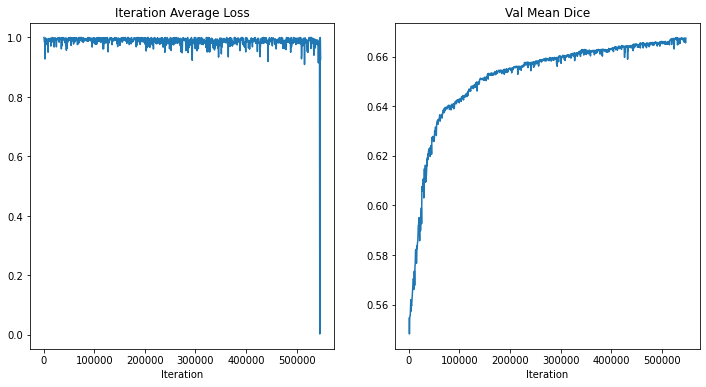

In [23]:
# Plot the loss and metric

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()